#### Исходные данные

Файл ferma_main.csv содержит данные о стаде фермера на текущий момент. Описание таблицы:

- Параметры корма коровы -- ЭКЕ (Энергетическая кормовая единица) — измерение питательности корма коровы; -- Сырой протеин — содержание сырого протеина в корме, в граммах; -- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
- Где паслась корова -- Тип пастбища — ландшафт лугов, на которых паслась корова.
- Особенности коровы -- id — номер коровы; -- Порода — порода коровы; -- Возраст — бинарный признак (менее_2_лет, более_2_лет); -- Имя Папы — порода папы коровы.
- Характеристики молока -- Жирность — содержание жиров в молоке, в процентах; -- Белок — содержание белков в молоке, в процентах; -- Вкус молока — оценка вкуса по личным критериям фермера; -- Удой — масса молока, которую корова даёт в год, в килограммах. Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера. Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична ferma_main.csv, кроме нескольких особенностей: -- Белок и Жирность молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм. -- Параметры кормления ЭКЕ, Сырой протеин, СПО отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. -- По новой схеме фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.

Цель исследования:
- Создать модель, которая поможет фермеру принимать верное решение о покупке коровы. Необходимо, чтобы модель отбирала коров, которые дадут не менее 6000 кг. вкусного молока в год.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats


RANDOM_STATE = 42

In [2]:
main_df = pd.read_csv('/datasets/ferma_main.csv', sep=';')
dad_df = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
buy_df = pd.read_csv('/datasets/cow_buy.csv', sep=';')

In [3]:
renamed_columns = {
    'Удой, кг': 'milk_kg',
    'ЭКЕ (Энергетическая кормовая единица)': 'eke',
    'Сырой протеин, г': 'protein_g',
    'СПО (Сахаро-протеиновое соотношение)': 'spo',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'dad_breed',
    'Жирность,%': 'fat_share',
    'Текущая_жирность,%': 'fat_share',
    'Белок,%': 'protein_share',
    'Текущий_уровень_белок,%': 'protein_share',
    'Вкус молока': 'taste',
    'Возраст': 'age',
    'Имя Папы': 'dad_name',
    'Имя_папы': 'dad_name',
}

main_df.rename(columns=renamed_columns, inplace=True)
dad_df.rename(columns=renamed_columns, inplace=True)
buy_df.rename(columns=renamed_columns, inplace=True)

In [4]:
display(main_df.columns)
display(dad_df.columns)
display(buy_df.columns)

Index(['id', 'milk_kg', 'eke', 'protein_g', 'spo', 'breed', 'pasture_type',
       'dad_breed', 'fat_share', 'protein_share', 'taste', 'age'],
      dtype='object')

Index(['id', 'dad_name'], dtype='object')

Index(['breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_share',
       'protein_share', 'age'],
      dtype='object')

In [5]:
numeric_columns_main = [
    'eke',
    'spo',
    'fat_share',
    'protein_share'
]

for col in numeric_columns_main:
    main_df[col] = main_df[col].str.replace(',', '.').astype(float)

categorical_columns_main = [
    'breed',
    'pasture_type', 
    'dad_breed',
    'taste',
    'age'
]

for col in categorical_columns_main:
    main_df[col] = main_df[col].astype('category')

dad_df['id'] = dad_df['id'].astype('int')

numeric_columns_buy = [
    'fat_share',
    'protein_share'
]

for col in numeric_columns_buy:
    buy_df[col] = buy_df[col].str.replace(',', '.').astype(float)
    
categorical_columns_buy = [
    'breed',
    'pasture_type', 
    'dad_breed',
    'age'
]

for col in categorical_columns_buy:
    buy_df[col] = buy_df[col].astype('category')

In [6]:
display(main_df.info())

display(dad_df.info())

buy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             634 non-null    int64   
 1   milk_kg        634 non-null    int64   
 2   eke            634 non-null    float64 
 3   protein_g      634 non-null    int64   
 4   spo            634 non-null    float64 
 5   breed          634 non-null    category
 6   pasture_type   634 non-null    category
 7   dad_breed      634 non-null    category
 8   fat_share      634 non-null    float64 
 9   protein_share  634 non-null    float64 
 10  taste          634 non-null    category
 11  age            634 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 38.5 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   breed          20 non-null     category
 1   pasture_type   20 non-null     category
 2   dad_breed      20 non-null     category
 3   dad_name       20 non-null     object  
 4   fat_share      20 non-null     float64 
 5   protein_share  20 non-null     float64 
 6   age            20 non-null     category
dtypes: category(4), float64(2), object(1)
memory usage: 1.2+ KB


В ходе загрузки данных выполнили:
- зписали данные в датафреймы 'main_df' 'dad_df' и 'buy_df' соответственно, разделяя их по ';'
- привели названия всех столбцов к правильному виду
- изменили типы данных
- просмотрели данные и выяснили
    - в таблице 'main_df' 634 строки, пропусков нет
    - в таблице 'dad_df' 629 строк, пропусков нет
    - в таблице 'buy_df' 20 строк, пропусков нет

##  Предобработка данных

In [7]:
display(main_df.isna().sum())
display(dad_df.isna().sum())
buy_df.isna().sum()

id               0
milk_kg          0
eke              0
protein_g        0
spo              0
breed            0
pasture_type     0
dad_breed        0
fat_share        0
protein_share    0
taste            0
age              0
dtype: int64

id          0
dad_name    0
dtype: int64

breed            0
pasture_type     0
dad_breed        0
dad_name         0
fat_share        0
protein_share    0
age              0
dtype: int64

Проверили таблицы на пропуски еще раз, пропусков не обнаружили

In [8]:
display(main_df.duplicated().sum())
display(dad_df.duplicated().sum())
buy_df.duplicated().sum()

5

0

4

In [9]:
main_df = main_df.drop_duplicates()
dad_df = dad_df.drop_duplicates()
buy_df = buy_df.drop_duplicates()

In [10]:
display(main_df.duplicated().sum())
display(dad_df.duplicated().sum())
buy_df.duplicated().sum()

0

0

0

Далее будем проверять на неявные дубликаты, сначала выведем все категории из категориальных данных

In [11]:
categorical_main = [
    'breed',
    'pasture_type', 
    'dad_breed',
    'taste',
    'age'
]

for col in categorical_main:
    display(main_df[col].value_counts())
    
categorical_buy = [
    'breed',
    'pasture_type', 
    'dad_breed',
    'age'
]

for col in categorical_buy:
    display(buy_df[col].value_counts())

Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: breed, dtype: int64

Холмистое    351
Равнинное    253
Равнинные     25
Name: pasture_type, dtype: int64

Соверин    311
Айдиал     240
Айдиалл     78
Name: dad_breed, dtype: int64

вкусно       371
не вкусно    258
Name: taste, dtype: int64

более_2_лет    519
менее_2_лет    110
Name: age, dtype: int64

Вис Бик Айдиал     8
РефлешнСоверинг    8
Name: breed, dtype: int64

равнинное    8
холмистое    8
Name: pasture_type, dtype: int64

Соверин    10
Айдиал      6
Name: dad_breed, dtype: int64

более_2_лет    11
менее_2_лет     5
Name: age, dtype: int64

Заметили дубликаты в датафрейме 'main_df' в столбцах 'тип_пастбища' и 'порода_папы_быка', приведем их к одному

In [12]:
pasture_mapping = {
    'Равнинные': 'Равнинное'
}

bull_mapping = {
    'Айдиалл': 'Айдиал'
}

main_df['pasture_type'] = main_df['pasture_type'].replace(pasture_mapping)
main_df['dad_breed'] = main_df['dad_breed'].replace(bull_mapping)

In [13]:
categorical_main = [
    'pasture_type', 
    'dad_breed'
]

for col in categorical_main:
    display(main_df[col].value_counts())

Холмистое    351
Равнинное    278
Name: pasture_type, dtype: int64

Айдиал     318
Соверин    311
Name: dad_breed, dtype: int64

Данные не потеряли, замена дубликатов прошла успешно

В ходе предобработки данных выполнили:
- еще раз проверили наличие пропусков, убедились в их отсутствии
- нашли 5, 0 и 4 полных дубликата в таблицах 'main_df' 'dad_df' и 'buy_df' соответственно, избавились от них
- проверили датасеты на наличие неявных дубликатов, тоже от них избавились

## Исследовательский анализ данных

### для main_df

In [14]:
display(main_df.describe())
display(dad_df.describe())
buy_df.describe()

,id,milk_kg,eke,protein_g,spo,fat_share,protein_share
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


,fat_share,protein_share
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


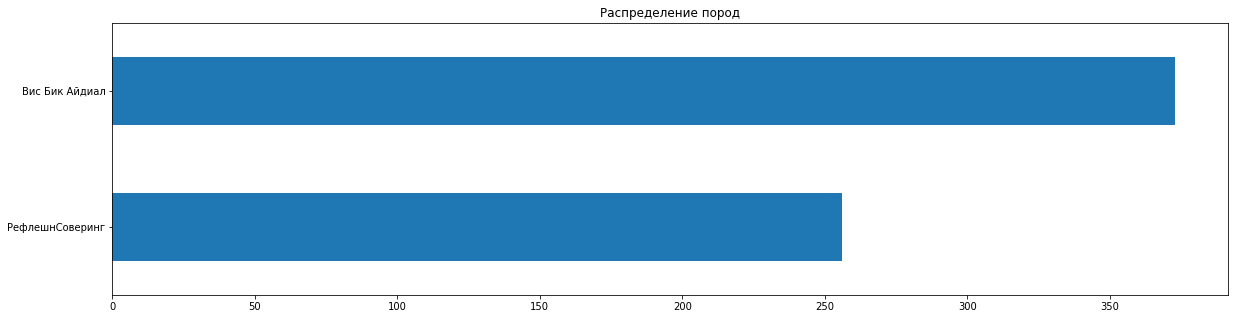

In [15]:
main_df['breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пород')
plt.show()

Коров породы айдал значительно больше

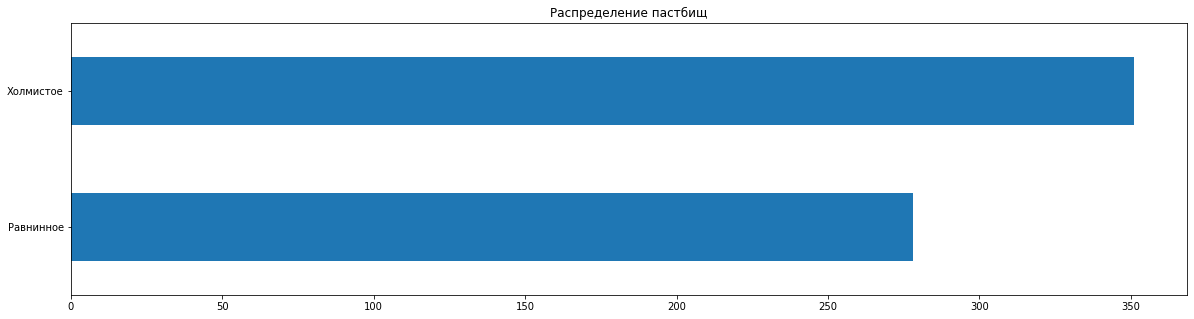

In [16]:
main_df['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пастбищ')
plt.show()

Больше холмистых

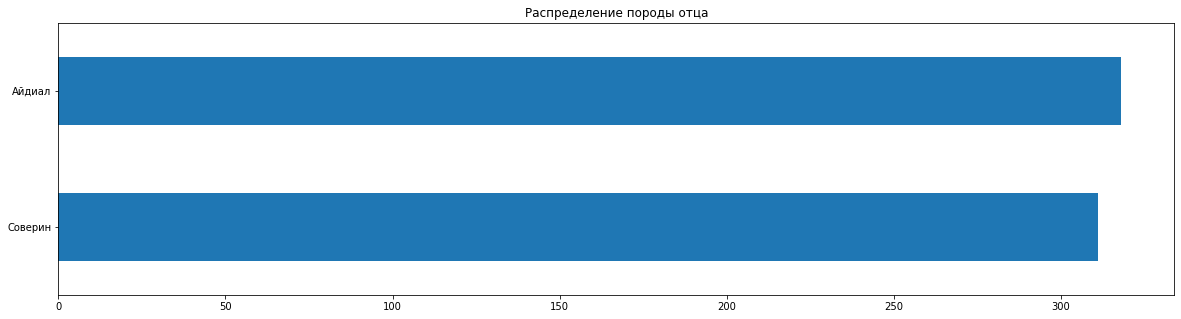

In [17]:
main_df['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение породы отца')
plt.show()

Быков породы айдал немного больше

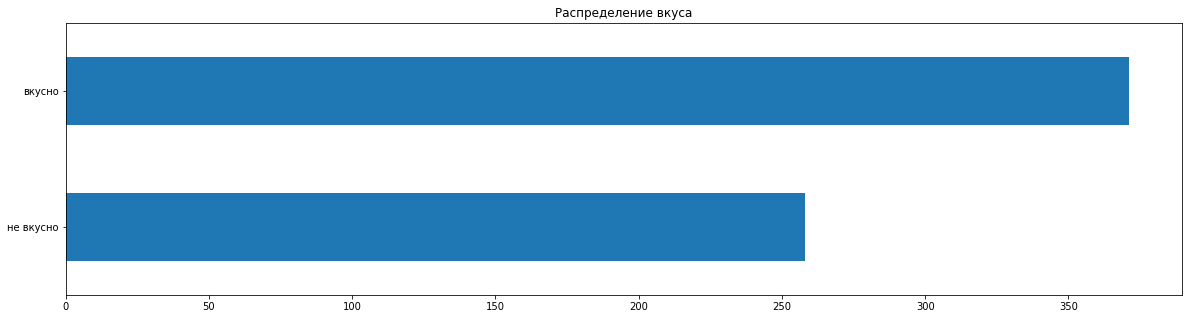

In [18]:
main_df['taste'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение вкуса')
plt.show()

Вкусное молоко встречается чаще

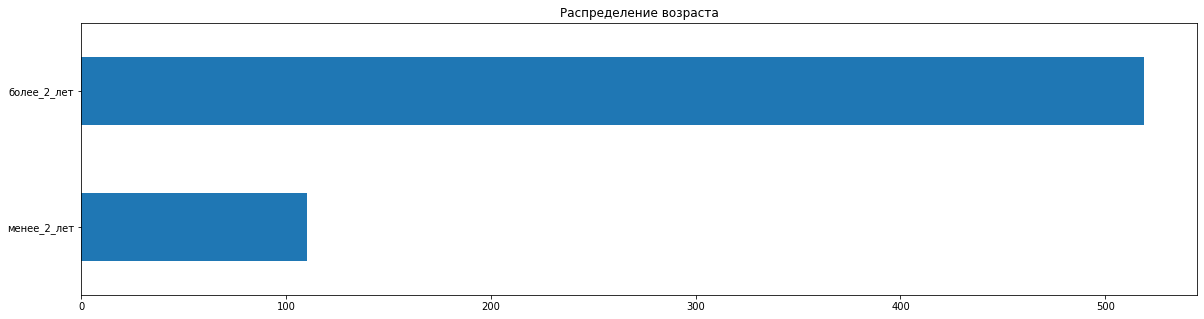

In [19]:
main_df['age'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение возраста')
plt.show()

Молодых коров намного меньше

Для количественных признаков напишем функцию, которая сразу будет выводить 'ящик с усами' и гистограмму 

In [20]:
def plot_numeric(df, variable, title, xlabel, bins):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    f.suptitle(title, fontsize=20)
    ax1.boxplot(df[variable])
    ax1.set_title('Ящик с усами')
    ax1.set_xlabel(xlabel)
    ax1.set_xticks([])

    ax2.hist(df[variable], bins=bins)
    ax2.set_title('Гистограмма')
    ax2.set_xlabel(xlabel)

    plt.show()

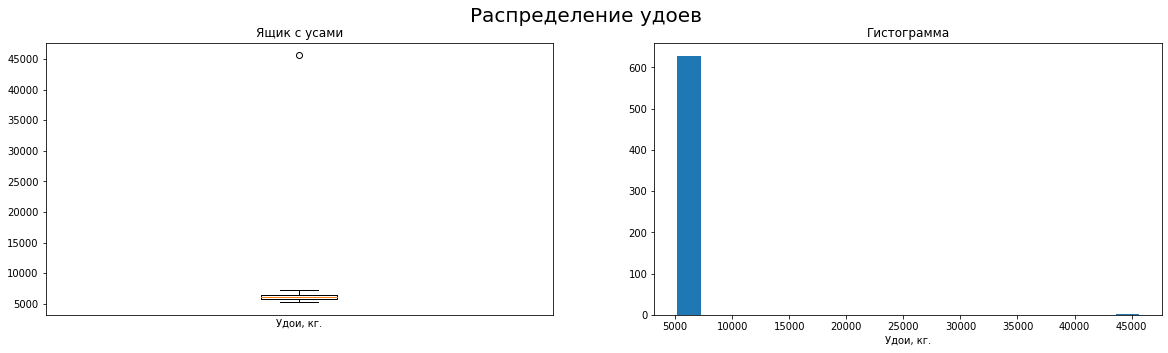

In [21]:
plot_numeric(main_df, 'milk_kg', 'Распределение удоев', 'Удои, кг.', 20)

Имеются выбросы в значении ~45000. Вероятнее всего указывали значения в граммах вместо кг. Можно избавиться от этих значений

In [22]:
main_df = main_df[main_df['milk_kg'] <= 15000]

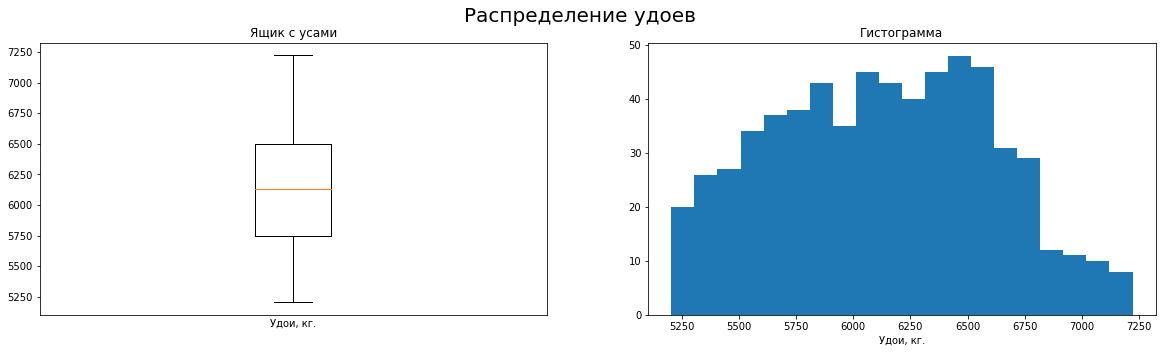

In [23]:
plot_numeric(main_df, 'milk_kg', 'Распределение удоев', 'Удои, кг.', 20)

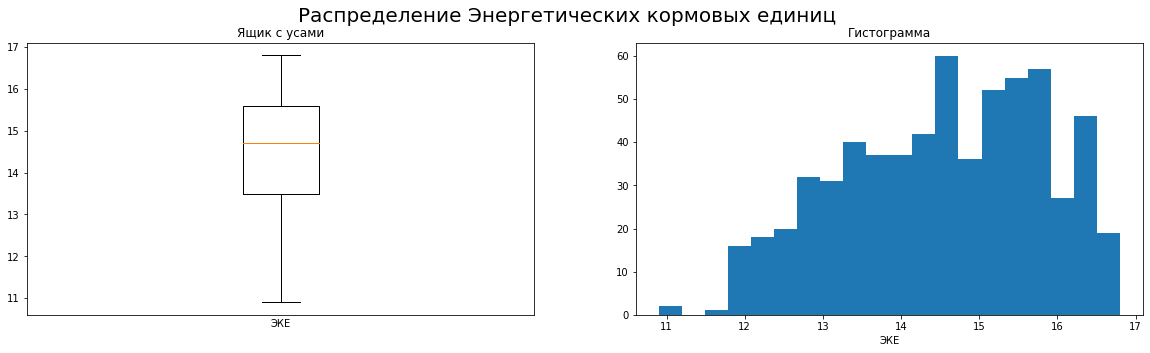

In [24]:
plot_numeric(
    main_df, 'eke', 'Распределение Энергетических кормовых единиц', 'ЭКЕ', 20
)

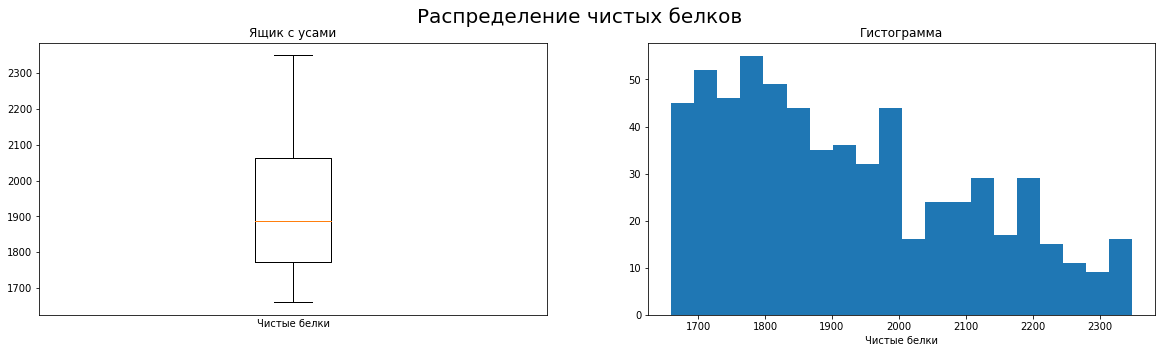

In [25]:
plot_numeric(
    main_df, 'protein_g', 'Распределение чистых белков', 'Чистые белки', 20
)

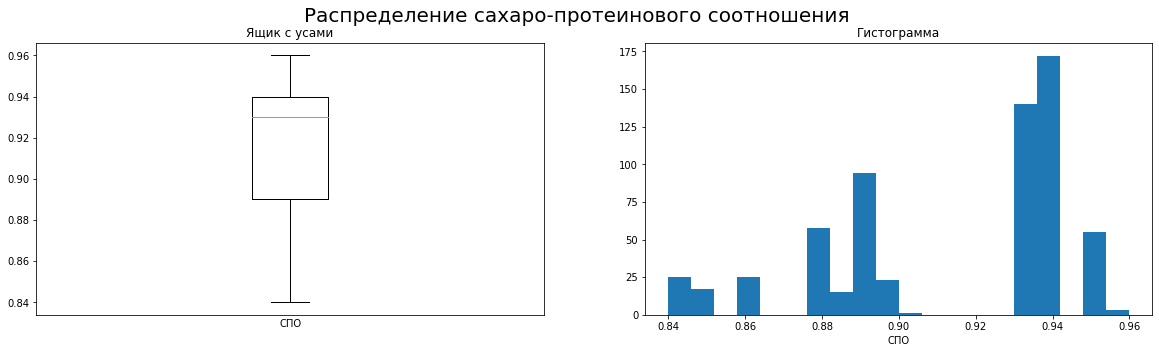

In [26]:
plot_numeric(
    main_df, 'spo', 'Распределение сахаро-протеинового соотношения', 'СПО', 20
)

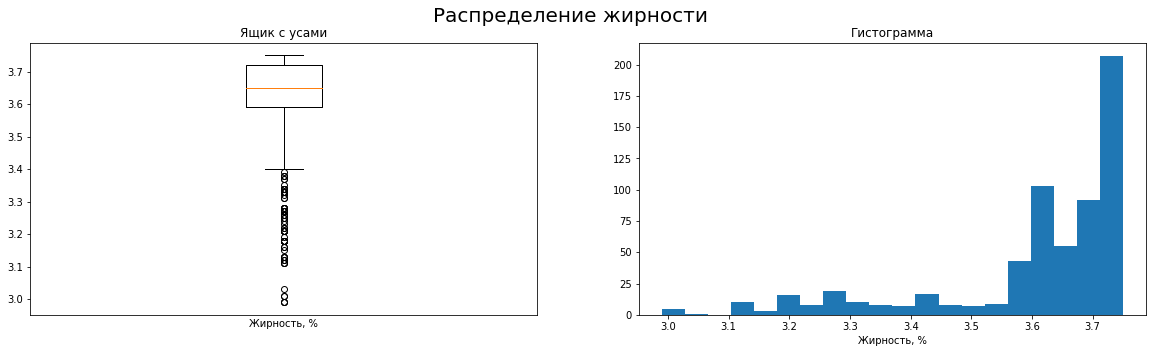

In [27]:
plot_numeric(main_df, 'fat_share', 'Распределение жирности', 'Жирность, %', 20)

Видим выбросы около 3-х процентов, но ничего подозрительного тут нет

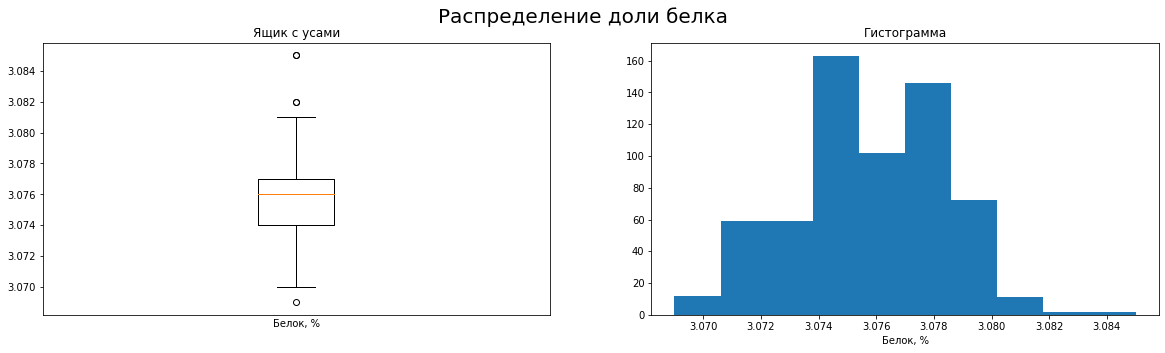

In [28]:
plot_numeric(main_df, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

Значения выбросов незначительно отличаются от большей части данных

### для dad_df

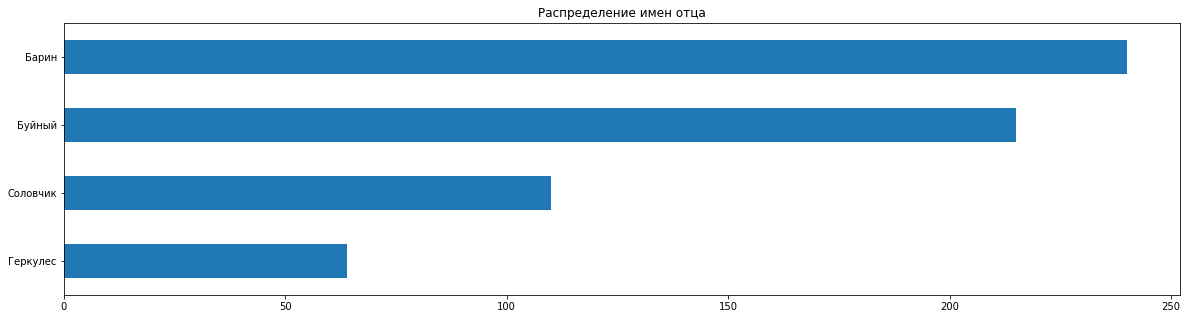

In [29]:
dad_df['dad_name'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение имен отца')
plt.show()

### для buy_df

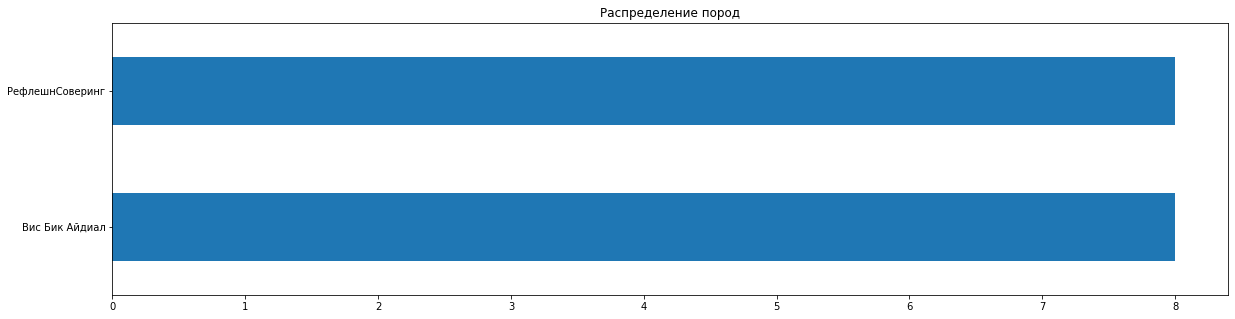

In [30]:
buy_df['breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пород')
plt.show()

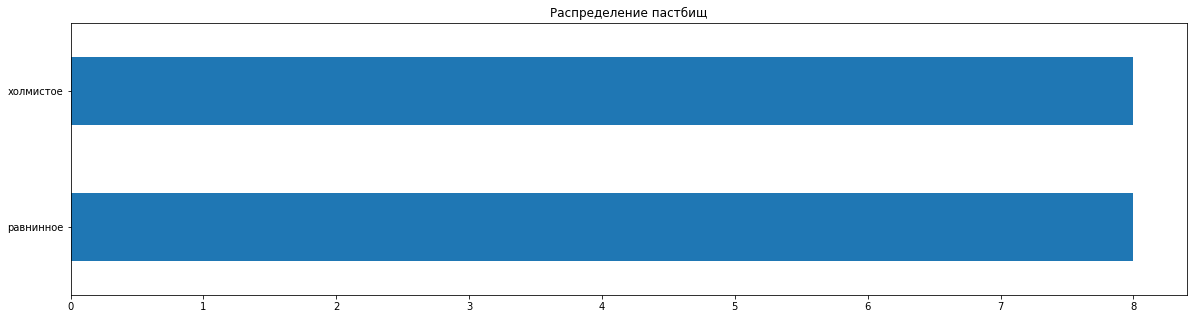

In [31]:
buy_df['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пастбищ')
plt.show()

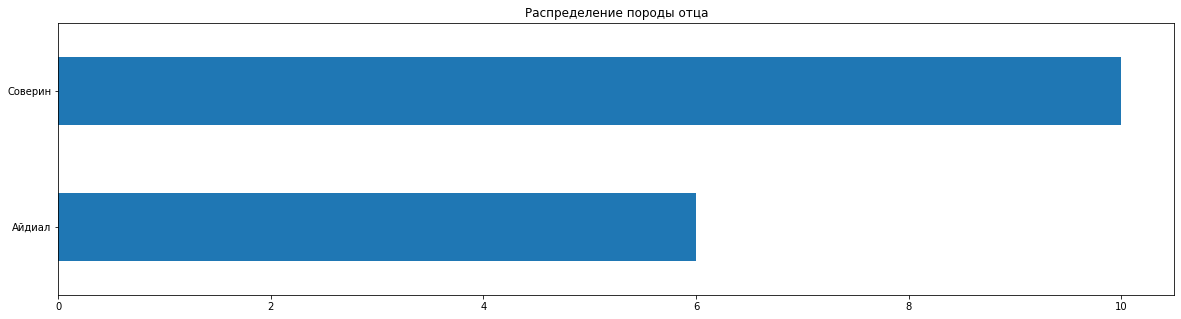

In [32]:
buy_df['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение породы отца')
plt.show()

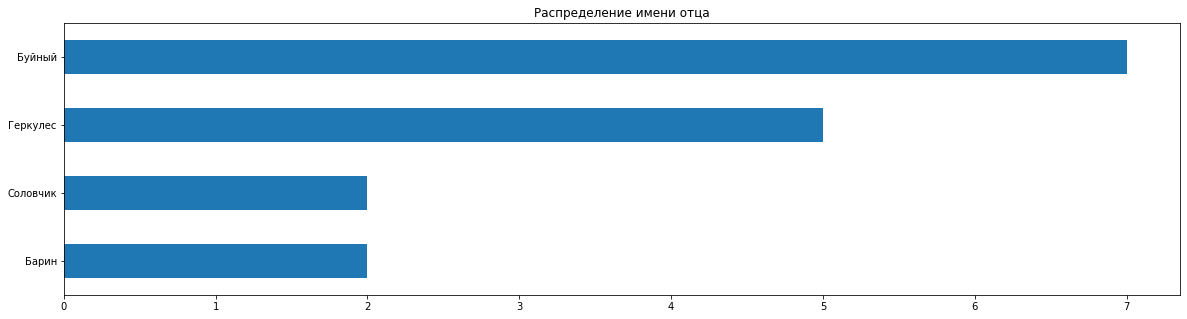

In [33]:
buy_df['dad_name'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение имени отца')
plt.show()

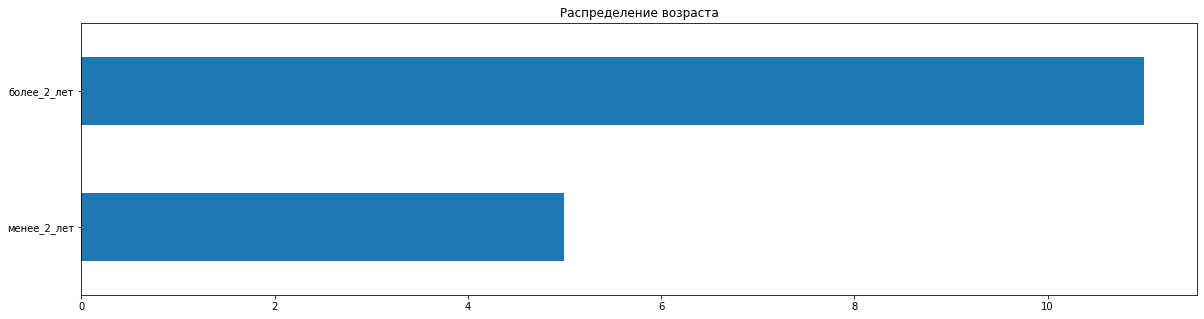

In [34]:
buy_df['age'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение возраста')
plt.show()

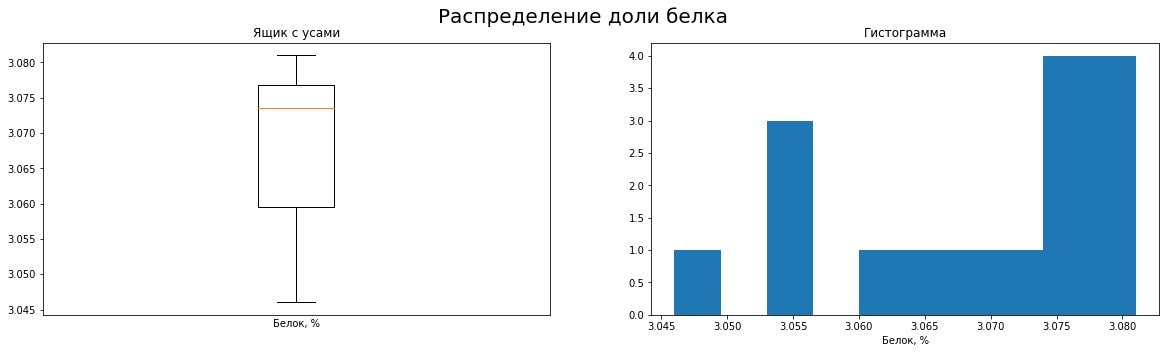

In [35]:
plot_numeric(buy_df, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

В ходе исследовательского анализа выполнили:
- просмотрели описание всех столбцов в трех датасетах
- нарисовали графики для категориальных и количественных признаков
- избавились от выбросов там, где это было возможно

## Корреляционный анализ

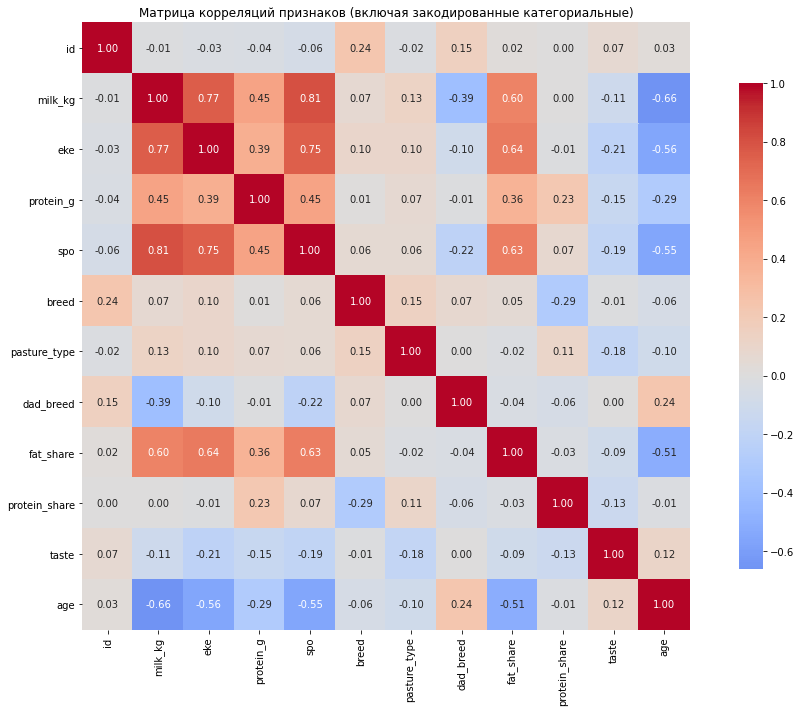

Корреляции с признаком 'milk_kg':
milk_kg          1.000000
spo              0.806339
eke              0.765098
fat_share        0.600902
protein_g        0.446731
pasture_type     0.130608
breed            0.067342
protein_share    0.002966
id              -0.006816
taste           -0.112839
dad_breed       -0.392671
age             -0.660707
Name: milk_kg, dtype: float64

Корреляции с признаком 'taste':
taste            1.000000
age              0.117584
id               0.071675
dad_breed        0.001505
breed           -0.007719
fat_share       -0.094251
milk_kg         -0.112839
protein_share   -0.128186
protein_g       -0.148606
pasture_type    -0.181083
spo             -0.189197
eke             -0.214418
Name: taste, dtype: float64

Сильные корреляции с milk_kg (|r| > 0.5):
milk_kg      1.000000
spo          0.806339
eke          0.765098
fat_share    0.600902
age         -0.660707
Name: milk_kg, dtype: float64

Сильные корреляции с taste (|r| > 0.5):
taste    1.0
Name: taste, d

In [36]:
main_df_numeric = main_df.copy()

categorical_columns = ['breed', 'pasture_type', 'dad_breed', 'taste', 'age']

label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    main_df_numeric[column] = le.fit_transform(main_df[column])
    label_encoders[column] = le

correlation_matrix = main_df_numeric.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций признаков (включая закодированные категориальные)')
plt.tight_layout()
plt.show()

print("Корреляции с признаком 'milk_kg':")
print(correlation_matrix['milk_kg'].sort_values(ascending=False))

print("\nКорреляции с признаком 'taste':")
print(correlation_matrix['taste'].sort_values(ascending=False))

strong_corr_milk = correlation_matrix['milk_kg'][abs(correlation_matrix['milk_kg']) > 0.5]
strong_corr_taste = correlation_matrix['taste'][abs(correlation_matrix['taste']) > 0.5]

print(f"\nСильные корреляции с milk_kg (|r| > 0.5):")
print(strong_corr_milk.sort_values(ascending=False))

print(f"\nСильные корреляции с taste (|r| > 0.5):")
print(strong_corr_taste.sort_values(ascending=False))

Удой молока (milk_kg)
Сильная положительная корреляция:
- spo (Сахаро-протеиновое соотношение): +0.81 - наиболее значимый фактор
- eke (Энергетическая кормовая единица): +0.77 - ключевой параметр питательности
- fat_share (Жирность молока): +0.60 - неожиданно положительная связь

Сильная отрицательная корреляция:
- age (Возраст): -0.66 - молодые коровы (<2 лет) дают больше молока

Умеренная корреляция:
- protein_g (Сырой протеин): +0.45 - важный, но менее значимый фактор

Вкус молока (taste)
- Отсутствие сильных линейных связей: Ни один признак не показывает корреляцию > 0.5

Слабые отрицательные тенденции:
- eke (-0.21) и spo (-0.19) - более питательный корм может негативно влиять на вкус
- pasture_type (-0.18) - тип пастбища слабо влияет на вкус

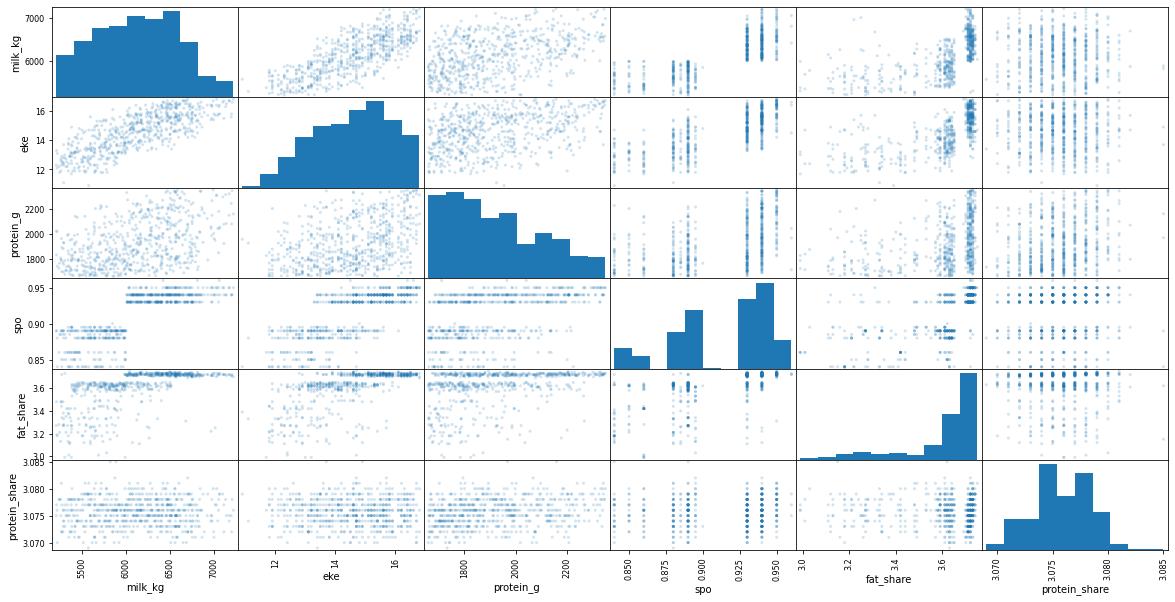

In [37]:
pd.plotting.scatter_matrix(
    main_df.drop(['id'], axis=1), alpha=0.2, figsize=(20, 10)
)
plt.show()

Больше всего с целевой переменной коррелируют характеристики корма: ЭКЕ, количество граммов чистого протеина и СПО.

1. Тип взаимосвязи между целевым и входными признаками
Для целевой переменной milk_kg (Удой, кг):
Сильные линейные положительные связи: spo (+0.81), eke (+0.77), fat_share (+0.60)
Сильная линейная отрицательная связь: age (-0.66) - обратная зависимость
Умеренная линейная положительная связь: protein_g (+0.45)

Для целевой переменной taste (Вкус молока):
Слабые линейные связи: Все корреляции < |0.5|
Отсутствие выраженных линейных зависимостей

2. Наличие нелинейных связей
Да, нелинейные связи присутствуют:
- Для параметров корма (eke, spo, protein_g) наблюдается нелинейность - после определенных значений дополнительное увеличение питательности не дает пропорционального роста удоев
- Для fat_share существуют критические значения, после которых зависимость меняет характер
- Для разных пород и типов пастбищ характер зависимостей различается

Рекомендации по учету нелинейностей:
- Добавить полиномиальные признаки второй степени: eke², spo², protein_g²
- Рассмотреть нелинейные модели (Random Forest, Gradient Boosting)

3. Мультиколлинеарность между входными признаками
Да, мультиколлинеарность наблюдается:
- Сильная корреляция между параметрами корма: eke, spo, protein_g тесно связаны между собой

## Обучение модели линейной регрессии

Нужно избавиться от переменных, которые не могут повлиять на удой. Это в первую очередь характеристики молока. Характеристики корма, порода отца и тип пастбища уже могут повлиять на удой. Их оставим и закодируем.

In [38]:
main_for_learning = main_df.copy()

Произведем разбивку на выборки

In [39]:
X = main_for_learning.reset_index().drop(
    ['milk_kg', 'index', 'id', 'taste', 'protein_share', 'fat_share'], axis=1
)
y = main_for_learning.reset_index().drop(['index'], axis=1)['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

print(
    f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)'''
)

X_train nrows: 471 (75%)
X_test nrows:  157 (25%)


In [40]:
enc = OneHotEncoder(drop='first')

In [41]:
cat_X_train = enc.fit_transform(
    X_train[['breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()

cat_X_test = enc.transform(
    X_test[['breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()
# делаем преобразование и смотрим на получившиеся названия столбцов,
# чтобы правильно переименовать
enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_Холмистое',
       'x3_менее_2_лет'], dtype=object)

In [42]:
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)
display(cat_X_train_df.head())
cat_X_train_df.shape

,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0


(471, 4)

In [43]:
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)


X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)
display(X_train_for_learning.head())
X_train_for_learning.shape

,eke,protein_g,spo,breed,pasture_type,dad_breed,age,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,16.5,2123,0.94,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,1.0,1.0,1.0,0.0
1,12.5,1889,0.89,РефлешнСоверинг,Холмистое,Соверин,менее_2_лет,1.0,1.0,1.0,1.0
2,14.7,1671,0.88,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0
3,14.4,2063,0.94,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,0.0,0.0,1.0,0.0
4,13.1,2077,0.89,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0


(471, 11)

In [44]:
X_train_for_learning = X_train_for_learning.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age'], axis=1
)

X_test_for_learning = X_test_for_learning.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age'], axis=1
)

display(X_train_for_learning.head())
X_train_for_learning.shape

,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,16.5,2123,0.94,1.0,1.0,1.0,0.0
1,12.5,1889,0.89,1.0,1.0,1.0,1.0
2,14.7,1671,0.88,0.0,0.0,0.0,0.0
3,14.4,2063,0.94,0.0,0.0,1.0,0.0
4,13.1,2077,0.89,0.0,0.0,0.0,0.0


(471, 7)

In [45]:
num_cols = ['eke', 'protein_g', 'spo']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
]

In [46]:
scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num,
    columns=num_cols,
    index=X_train_for_learning.index,
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols, index=X_test_for_learning.index
)

In [47]:
X_train_for_learning = X_train_for_learning_num.merge(
    X_train_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

X_test_for_learning = X_test_for_learning_num.merge(
    X_test_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,1.502378,1.079523,0.837130,1.0,1.0,1.0,0.0
1,-1.557270,-0.196920,-0.703660,1.0,1.0,1.0,1.0
2,0.125537,-1.386085,-1.011818,0.0,0.0,0.0,0.0
3,-0.103937,0.752230,0.837130,0.0,0.0,1.0,0.0
4,-1.098323,0.828598,-0.703660,0.0,0.0,0.0,0.0


Train (471, 7)


,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,-0.486393,-0.813322,-1.011818,0.0,0.0,1.0,0.0
1,1.425887,0.026730,0.837130,1.0,1.0,1.0,0.0
2,-0.486393,-0.682405,-1.628134,1.0,1.0,1.0,1.0
3,-0.945340,-1.058792,-1.011818,0.0,1.0,0.0,0.0
4,0.584484,-1.413360,-0.703660,0.0,1.0,1.0,0.0


Test (157, 7)


In [48]:
def model_test(X_train, y_train, X_test, y_test, linear_model):
    '''Обучает и тестирует модель. Выводит r2 и график распределения остатков.
    Возвращает обученную модель'''

    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    print(f'R2 score: {r2}')

    plt.scatter(y_pred, y_test)
    plt.title('График остатков')
    plt.xlabel('Прогнозные значения модели')
    plt.ylabel('Реальные значения')
    plt.show()

    return linear_model

R2 score: 0.7844078173416967


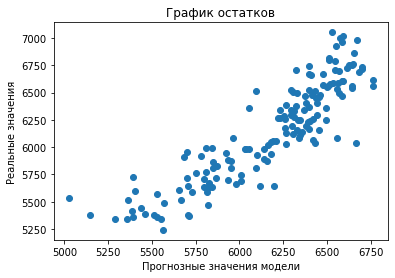

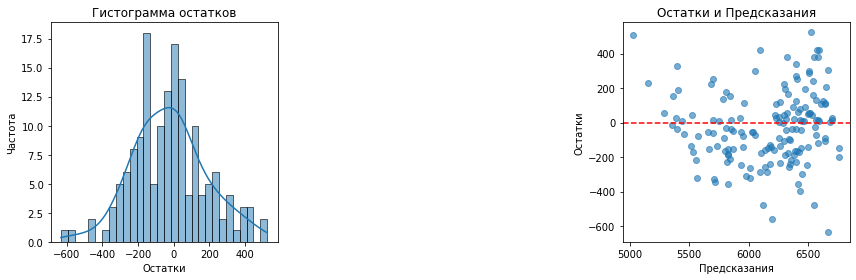

In [49]:
linear_model = LinearRegression()

model = model_test(
    X_train_for_learning, y_train, X_test_for_learning, y_test, linear_model
)

y_pred = model.predict(X_test_for_learning)

residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Гистограмма остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")

plt.subplot(1, 3, 3)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Остатки и Предсказания")
plt.xlabel("Предсказания")
plt.ylabel("Остатки")

plt.tight_layout()
plt.show()

R2 ближе к единице, чем к минус бесконечности - это говорит и неплохом качестве модели. Остатки распределены неравномерно. Наблюдается линейная зависимость с убывающей дисперсией.

Графики показывают, что СПО и Удой связаны нелинейно. Исключим нелинейность: переведём СПО в категориальный признак, выявив и использовав границу нелинейности.

In [50]:
main_for_learning.loc[:, 'is_high_spo'] = (
    main_for_learning.loc[:, 'spo'] > 0.92
) * 1.0

main_for_learning.head()

,id,milk_kg,eke,protein_g,spo,breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0


ЭКЕ и Удой также связаны нелинейно. Исключим нелинейность: введём новый признак «ЭКЕ в квадрате».

In [51]:
main_for_learning.loc[:, 'eke2'] = main_for_learning.loc[:, 'eke'] ** 2

main_for_learning.head()

,id,milk_kg,eke,protein_g,spo,breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo,eke2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84


In [52]:
X = main_for_learning.drop(
    ['milk_kg', 'id', 'taste', 'protein_share', 'fat_share', 'eke', 'spo'],
    axis=1,
)
y = main_for_learning['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

print(
    f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)'''
)

X_train nrows: 471 (75%)
X_test nrows:  157 (25%)


In [53]:
num_cols = ['eke2', 'protein_g']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
    'is_high_spo',
]


enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(
    X_train[['breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()

cat_X_test = enc.transform(
    X_test[['breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()

In [54]:
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)

# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)


X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)

In [55]:

# Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num,
    columns=num_cols,
    index=X_train_for_learning.index,
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols, index=X_test_for_learning.index
)

X_train_for_learning = X_train_for_learning_num.merge(
    X_train_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

X_test_for_learning = X_test_for_learning_num.merge(
    X_test_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo
0,1.577968,1.079523,1.0,1.0,1.0,0.0,1.0
1,-1.511438,-0.196920,1.0,1.0,1.0,1.0,0.0
2,0.082269,-1.386085,0.0,0.0,0.0,0.0,0.0
3,-0.150235,0.752230,0.0,0.0,1.0,0.0,1.0
4,-1.102358,0.828598,0.0,0.0,0.0,0.0,0.0


Train (471, 7)


,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo
0,-0.527089,-0.813322,0.0,0.0,1.0,0.0,0.0
1,1.490346,0.026730,1.0,1.0,1.0,0.0,1.0
2,-0.527089,-0.682405,1.0,1.0,1.0,1.0,0.0
3,-0.961737,-1.058792,0.0,1.0,0.0,0.0,0.0
4,0.561660,-1.413360,0.0,1.0,1.0,0.0,0.0


Test (157, 7)


Тест модели на новых выборках

R2 score: 0.8180879926867504


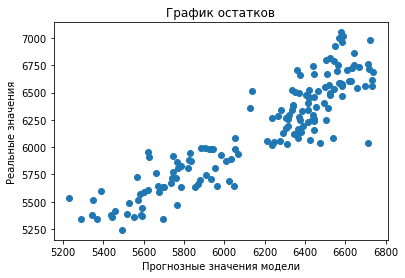

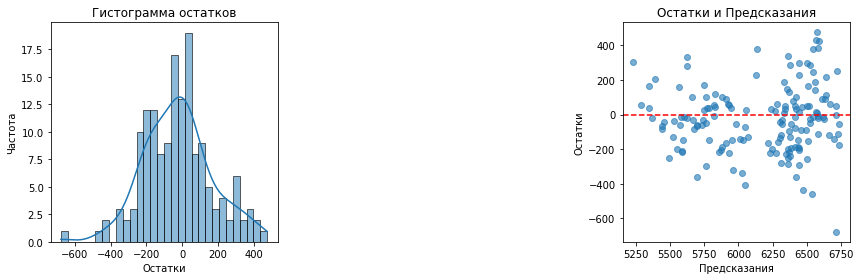

In [56]:
model = model_test(
    X_train_for_learning, y_train, X_test_for_learning, y_test, linear_model
)

y_pred = model.predict(X_test_for_learning)

residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Гистограмма остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")

plt.subplot(1, 3, 3)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Остатки и Предсказания")
plt.xlabel("Предсказания")
plt.ylabel("Остатки")

plt.tight_layout()
plt.show()

R2 удалось увеличить до 0.818. Качество модели улучшилось.

Данные можно обогатить признаком 'Имя папы'. Попробуем.

In [57]:
main_for_learning = main_for_learning.merge(dad_df)

main_for_learning.head()

,id,milk_kg,eke,protein_g,spo,breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo,eke2,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84,Барин


In [58]:
X = main_for_learning.drop(
    ['milk_kg', 'id', 'taste', 'protein_share', 'fat_share', 'eke', 'spo'],
    axis=1,
)
y = main_for_learning['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

print(
    f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)'''
)

num_cols = ['eke2', 'protein_g']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
    'is_high_spo',
    'dad_name',
]


enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(
    X_train[['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']]
).toarray()

cat_X_test = enc.transform(
    X_test[['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']]
).toarray()

enc.get_feature_names()

X_train nrows: 471 (75%)
X_test nrows:  157 (25%)


array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_Холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [59]:
# Переименовываем столбцы
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

In [60]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)

X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,breed,pasture_type,dad_breed,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,2123,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,1.0,272.25,Соловчик,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1889,РефлешнСоверинг,Холмистое,Соверин,менее_2_лет,0.0,156.25,Барин,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1671,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0.0,216.09,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2063,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,1.0,207.36,Буйный,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2077,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0.0,171.61,Геркулес,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train (471, 15)


,protein_g,breed,pasture_type,dad_breed,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1776,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,0.0,193.21,Геркулес,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1930,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,1.0,268.96,Соловчик,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1800,РефлешнСоверинг,Холмистое,Соверин,менее_2_лет,0.0,193.21,Барин,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1731,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,0.0,176.89,Барин,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1666,Вис Бик Айдиал,Холмистое,Соверин,более_2_лет,0.0,234.09,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (157, 15)


In [61]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)

X_test_for_learning = X_test_for_learning.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)
display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,2123,1.0,272.25,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1889,0.0,156.25,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1671,0.0,216.09,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2063,1.0,207.36,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2077,0.0,171.61,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train (471, 10)


,protein_g,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1776,0.0,193.21,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1930,1.0,268.96,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1800,0.0,193.21,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1731,0.0,176.89,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1666,0.0,234.09,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (157, 10)


In [62]:
num_cols = ['eke2', 'protein_g']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
    'is_high_spo',
    'is_furious',
    'is_hercules',
    'is_nightingale',
]

In [63]:
# Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num,
    columns=num_cols,
    index=X_train_for_learning.index,
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols, index=X_test_for_learning.index
)

X_train_for_learning = X_train_for_learning_num.merge(
    X_train_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

X_test_for_learning = X_test_for_learning_num.merge(
    X_test_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo,is_furious,is_hercules,is_nightingale
0,1.577968,1.079523,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-1.511438,-0.196920,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.082269,-1.386085,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.150235,0.752230,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,-1.102358,0.828598,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train (471, 10)


,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo,is_furious,is_hercules,is_nightingale
0,-0.527089,-0.813322,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.490346,0.026730,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,-0.527089,-0.682405,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,-0.961737,-1.058792,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.561660,-1.413360,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Test (157, 10)


R2 score: 0.8247542745210406


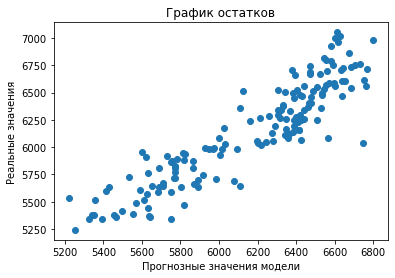

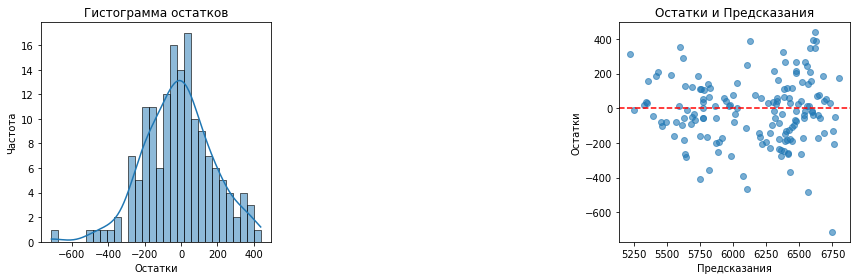

In [64]:
model = model_test(
    X_train_for_learning, y_train, X_test_for_learning, y_test, linear_model
)

y_pred = model.predict(X_test_for_learning)

residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Гистограмма остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")

plt.subplot(1, 3, 3)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Остатки и Предсказания")
plt.xlabel("Предсказания")
plt.ylabel("Остатки")

plt.tight_layout()
plt.show()

Добавив имена быков удалось ещё немного улучшить модель.

### Прогнозы удоев для новых коров

In [65]:
display(buy_df.head())
print(f'''New: {buy_df.shape}''')

,breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


New: (16, 7)


In [66]:
buy_df['eke2'] = (main_for_learning['eke'].median() * 1.05) ** 2
buy_df['protein_g'] = main_for_learning['protein_g'].median() * 1.05
buy_df['is_high_spo'] = ((main_for_learning['spo'].median() * 1.05) > 0.92) * 1.0

# отложим обогащенные данные, пригодятся для логистической регрессии
cow_log = buy_df.copy()

display(buy_df.head())
print(f'''New: {buy_df.shape}''')

,breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,238.239225,1982.4,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,238.239225,1982.4,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,238.239225,1982.4,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,238.239225,1982.4,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,238.239225,1982.4,1.0


New: (16, 10)


In [67]:
buy_df['pasture_type'] = buy_df['pasture_type'].replace({
    'холмистое': 'Холмистое',
    'равнинное': 'Равнинное'
})

cow_cat = enc.transform(
    buy_df[['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']]
).toarray()

enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_Холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [68]:
cow_cat_df = pd.DataFrame(
    cow_cat,
    columns=[
        'is_sovering_bread',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cow_cat_df.head()

,is_sovering_bread,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [69]:
cow_num = scaler.transform(buy_df[['eke2', 'protein_g']])


buy_df.loc[:, ['eke2', 'protein_g']] = pd.DataFrame(
    cow_num, columns=['eke2', 'protein_g']
)

display(buy_df.head())
print(f'''New: {buy_df.shape}''')

,breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.672165,0.312566,1.0
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.672165,0.312566,1.0
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.672165,0.312566,1.0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.672165,0.312566,1.0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.672165,0.312566,1.0


New: (16, 10)


In [70]:
cow_final = buy_df.merge(cow_cat_df, left_index=True, right_index=True)

In [71]:
cow_final = cow_final.drop(
    [
        'breed',
        'pasture_type',
        'dad_breed',
        'dad_name',
        'fat_share',
        'protein_share',
        'age',
    ],
    axis=1,
)


display(cow_final.head())
print(f'''New: {cow_final.shape}''')

,eke2,protein_g,is_high_spo,is_sovering_bread,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.672165,0.312566,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.672165,0.312566,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.672165,0.312566,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.672165,0.312566,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.672165,0.312566,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


New: (13, 10)


In [72]:
predict = model.predict(cow_final)

full_predict = np.full(len(buy_df), np.nan)

valid_indices = cow_final.index

full_predict[valid_indices] = predict

cow_predict = buy_df.copy()
cow_predict['milk_predict'] = full_predict

In [73]:
cow_predict[cow_predict['milk_predict'] >= 6000]

,breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo,milk_predict
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.672165,0.312566,1.0,6038.006295
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.672165,0.312566,1.0,6603.528588
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.672165,0.312566,1.0,6050.290046
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.672165,0.312566,1.0,6242.838754
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.672165,0.312566,1.0,6679.311448
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.672165,0.312566,1.0,6404.069875
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.672165,0.312566,1.0,6325.531619
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,0.672165,0.312566,1.0,6038.006295
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.672165,0.312566,1.0,6108.800283
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,0.672165,0.312566,1.0,6050.290046


In [1]:
# Остатки на тренировке
train_pred = model.predict(X_train_for_learning)
residuals = y_train - train_pred

# Квантильные границы для ДИ
lower_q = np.quantile(residuals, 0.05)
upper_q = np.quantile(residuals, 0.95)

# Доверительный интервал для новых предсказаний
cow_predict['milk_pred_lower'] = cow_predict['milk_predict'] + lower_q
cow_predict['milk_pred_upper'] = cow_predict['milk_predict'] + upper_q

# Смотрим результат
display(cow_predict[['breed','dad_name','milk_predict','milk_pred_lower','milk_pred_upper']])


NameError: name 'model' is not defined

Удалось построить алгоритм обработки и подготовки данных для модели, обучить модель и получить прогнозы для удоев коров с фермы. В дальнейшем эту модель можно будет использовать и для покупки новых коров, обогащая её данными поступивших.
 
R2 = 82%

### Вкус молока

In [75]:
main_for_learning['taste'] = (main_for_learning['taste'] == 'вкусно') * 1.0

In [76]:
X = main_for_learning.drop(['id', 'milk_kg', 'eke', 'taste', 'spo'], axis=1)
y = main_for_learning['taste']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

In [77]:
X_train.head()

,protein_g,breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name
507,2123,РефлешнСоверинг,Холмистое,Соверин,3.70,3.074,более_2_лет,1.0,272.25,Соловчик
382,1889,РефлешнСоверинг,Холмистое,Соверин,3.34,3.072,менее_2_лет,0.0,156.25,Барин
586,1671,Вис Бик Айдиал,Равнинное,Айдиал,3.18,3.079,более_2_лет,0.0,216.09,Буйный
196,2063,Вис Бик Айдиал,Холмистое,Айдиал,3.62,3.079,более_2_лет,1.0,207.36,Буйный
327,2077,Вис Бик Айдиал,Равнинное,Айдиал,3.64,3.076,более_2_лет,0.0,171.61,Геркулес


In [78]:
num_cols = ['eke2', 'protein_g', 'fat_share', 'protein_share']
cat_cols = ['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']


enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(X_train[cat_cols]).toarray()

cat_X_test = enc.transform(X_test[cat_cols]).toarray()

enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_Холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [79]:
# Переименовываем столбцы
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

In [80]:
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)

X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,2123,РефлешнСоверинг,Холмистое,Соверин,3.70,3.074,более_2_лет,1.0,272.25,Соловчик,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1889,РефлешнСоверинг,Холмистое,Соверин,3.34,3.072,менее_2_лет,0.0,156.25,Барин,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1671,Вис Бик Айдиал,Равнинное,Айдиал,3.18,3.079,более_2_лет,0.0,216.09,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2063,Вис Бик Айдиал,Холмистое,Айдиал,3.62,3.079,более_2_лет,1.0,207.36,Буйный,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2077,Вис Бик Айдиал,Равнинное,Айдиал,3.64,3.076,более_2_лет,0.0,171.61,Геркулес,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train (471, 17)


,protein_g,breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1776,Вис Бик Айдиал,Холмистое,Айдиал,3.64,3.076,более_2_лет,0.0,193.21,Геркулес,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1930,РефлешнСоверинг,Холмистое,Соверин,3.71,3.073,более_2_лет,1.0,268.96,Соловчик,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1800,РефлешнСоверинг,Холмистое,Соверин,3.63,3.076,менее_2_лет,0.0,193.21,Барин,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1731,Вис Бик Айдиал,Равнинное,Соверин,3.62,3.074,более_2_лет,0.0,176.89,Барин,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1666,Вис Бик Айдиал,Холмистое,Соверин,3.62,3.076,более_2_лет,0.0,234.09,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (157, 17)


In [81]:
X_train_for_learning = X_train_for_learning.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)

X_test_for_learning = X_test_for_learning.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)
display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,2123,3.70,3.074,1.0,272.25,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1889,3.34,3.072,0.0,156.25,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1671,3.18,3.079,0.0,216.09,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2063,3.62,3.079,1.0,207.36,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2077,3.64,3.076,0.0,171.61,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train (471, 12)


,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1776,3.64,3.076,0.0,193.21,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1930,3.71,3.073,1.0,268.96,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1800,3.63,3.076,0.0,193.21,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1731,3.62,3.074,0.0,176.89,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1666,3.62,3.076,0.0,234.09,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (157, 12)


In [82]:
scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num, columns=num_cols
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols
)

In [83]:
X_train_for_learning[num_cols] = X_train_for_learning_num
X_test_for_learning[num_cols] = X_test_for_learning_num

display(X_train_for_learning.head())
print(f'''Train: {X_train_for_learning.shape}''')

display(X_test_for_learning.head())
print(f'''Test: {X_test_for_learning.shape}''')

,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1.079523,0.562532,-0.679069,1.0,1.577968,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,-0.196920,-1.601817,-1.452568,0.0,-1.511438,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,-1.386085,-2.563750,1.254677,0.0,0.082269,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.752230,0.081565,1.254677,1.0,-0.150235,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.828598,0.201807,0.094429,0.0,-1.102358,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train: (471, 12)


,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,-0.813322,0.201807,0.094429,0.0,-0.527089,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.026730,0.622652,-1.065819,1.0,1.490346,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,-0.682405,0.141686,0.094429,0.0,-0.527089,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,-1.058792,0.081565,-0.679069,0.0,-0.961737,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.413360,0.081565,0.094429,0.0,0.561660,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test: (157, 12)


In [84]:
logistic_model = LogisticRegression(random_state=RANDOM_STATE)

# Обучаем
logistic_model.fit(X_train_for_learning, y_train)

# Предсказываем
y_pred = logistic_model.predict(X_test_for_learning)

In [85]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(
    f'''Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}'''
)

confusion_matrix(y_test, y_pred)

Accuracy: 0.6305732484076433
Precision: 0.6229508196721312
Recall: 0.8636363636363636


array([[23, 46],
       [12, 76]])

Основная ошибка модели — модель часто ошибается, предсказывая «положительный» там, где его нет.
Самая важная метрика - ключевой показатель Recall (0.86), он высокий, и это хорошо;


In [86]:
y_proba = logistic_model.predict_proba(X_test_for_learning)

In [87]:
data = pd.DataFrame(
    {'y_valid': y_test.to_numpy(), 'y_pred': y_pred, 'y_proba': y_proba[:, 1]}
)
data.head()

,y_valid,y_pred,y_proba
0,1.0,1.0,0.671043
1,1.0,1.0,0.678813
2,1.0,1.0,0.654563
3,0.0,0.0,0.442719
4,1.0,1.0,0.794031


In [88]:
# Ищем порог, при котором получаем ложно-положительные срабатывания
data[(data['y_valid'] == 0.0) & (data['y_pred'] == 1.0)]['y_proba'].max()

0.8053043512310951

In [89]:
threshold = 0.806
y_pred_upgraded = (y_proba[:, 1] >= threshold) * 1
precision_score(y_test, y_pred_upgraded)

1.0

In [90]:
cow_log.head()
cow_log['pasture_type'] = cow_log['pasture_type'].replace({
    'равнинное': 'Равнинное',
    'холмистое': 'Холмистое'
})

In [91]:
cow_cat = enc.transform(cow_log[cat_cols]).toarray()

cow_cat_df = pd.DataFrame(
    cow_cat,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)


cow_log = cow_log.reset_index().drop(['index'], axis=1)
cow_log = cow_log.merge(cow_cat_df, left_index=True, right_index=True)

cow_log = cow_log.drop(
    ['breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)

cow_log.head()

,fat_share,protein_share,eke2,protein_g,is_high_spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,3.58,3.076,238.239225,1982.4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3.54,3.081,238.239225,1982.4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,3.59,3.074,238.239225,1982.4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.40,3.061,238.239225,1982.4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3.64,3.074,238.239225,1982.4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [92]:
cow_num = scaler.transform(cow_log[num_cols])
cow_log[num_cols] = pd.DataFrame(cow_num, columns=num_cols)

cow_log.head()

,fat_share,protein_share,eke2,protein_g,is_high_spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,-0.158918,0.094429,0.672165,0.312566,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.399401,2.028176,0.672165,0.312566,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,-0.098797,-0.679069,0.672165,0.312566,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.241093,-5.706810,0.672165,0.312566,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.201807,-0.679069,0.672165,0.312566,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [93]:
y_proba = logistic_model.predict_proba(cow_log)

y_proba

array([[0.1555648 , 0.8444352 ],
       [0.29379062, 0.70620938],
       [0.21026528, 0.78973472],
       [0.15772615, 0.84227385],
       [0.21135368, 0.78864632],
       [0.22782415, 0.77217585],
       [0.24455602, 0.75544398],
       [0.2093551 , 0.7906449 ],
       [0.16059361, 0.83940639],
       [0.20271619, 0.79728381],
       [0.11601366, 0.88398634],
       [0.19803579, 0.80196421],
       [0.16196644, 0.83803356],
       [0.18780099, 0.81219901],
       [0.20361195, 0.79638805],
       [0.27458346, 0.72541654]])

In [94]:

cm_upgraded = confusion_matrix(y_test, y_pred_upgraded)
acc_upgraded = accuracy_score(y_test, y_pred_upgraded)
prec_upgraded = precision_score(y_test, y_pred_upgraded)
rec_upgraded = recall_score(y_test, y_pred_upgraded)

print("Confusion matrix (при threshold=0.806):")
print(cm_upgraded)
print(f"Accuracy: {acc_upgraded:.3f}")
print(f"Precision: {prec_upgraded:.3f}")
print(f"Recall: {rec_upgraded:.3f}")

Confusion matrix (при threshold=0.806):
[[69  0]
 [80  8]]
Accuracy: 0.490
Precision: 1.000
Recall: 0.091


In [95]:
cow_predict['is_tasty'] = y_proba[:, 1] > 0.806

Фермер может купить только коров с индексами 0, 3, 12 и 15

In [96]:
cow_predict[
    (cow_predict['is_tasty'] == True) & (cow_predict['milk_predict'] >= 6000)
]

,breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo,milk_predict,milk_pred_lower,milk_pred_upper,is_tasty
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.672165,0.312566,1.0,6038.006295,5749.070609,6358.029887,True
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.672165,0.312566,1.0,6050.290046,5761.354359,6370.313637,True
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,0.672165,0.312566,1.0,6038.006295,5749.070609,6358.029887,True
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,0.672165,0.312566,1.0,6050.290046,5761.354359,6370.313637,True


## Итоговые выводы

В ходе проектной работы выполнили следующее:
- Записали данные в датафреймы;
- Изменили названия столбцов;
- Проверили данные на пропуски;
- Удалили явные и неявные дубликаты;
- Визуально оценили распределение переменных;
- Обогатили набор данных для обучения;
- Выявили нелинейные зависимости некоторых переменных;
- Предказали удои с помощью модели линейной регрессии;
- Предсказали вкус молока с помощью модели логистической регрессии;
- Выяснили, каких коров стоит купить заказчику, ими оказались коровы с индексами 0, 3, 12,